# Cluster-then-Search Engine - Clean Implementation

## Overview

Implementasi lengkap Cluster-then-Search Engine dengan dua fase:
1. **Phase 1 (Offline)**: Build clustering, BM25 models, vocabulary
2. **Phase 2 (Online)**: Search with typo correction, cluster filtering, RRF

## Features
- Typo correction (Levenshtein distance ≤ 2)
- Cluster filtering (cosine similarity with centroids)
- BM25 search ONLY within winning cluster
- Reciprocal Rank Fusion (RRF) untuk 3 fields (title, abstract, keyphrases)


## 1. Setup dan Instalasi Library

In [1]:
%pip install nltk scikit-learn numpy python-Levenshtein rank-bm25 datasets matplotlib seaborn -q
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print("Setup completed!")



[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Setup completed!


## 2. Import Library dan Inisialisasi


In [2]:
import numpy as np
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Levenshtein import distance as levenshtein_distance
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

## 3. Fungsi Preprocessing

Fungsi `preprocess()` melakukan preprocessing teks dengan langkah-langkah:
1. **Tokenization**: Memecah teks menjadi kata-kata individual
2. **Lowercasing**: Mengubah semua huruf menjadi lowercase
3. **Filtering**: Menghapus non-alphabetic characters
4. **Stopword removal**: Menghapus kata-kata umum yang tidak informatif (the, is, a, etc.)
5. **Stemming**: Mengurangi kata ke bentuk dasarnya (computing → comput, learning → learn)


In [3]:
def preprocess(text):
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens
test = "Computer Vision Machine Learning"
print(f"Original: {test}")
print(f"Processed: {preprocess(test)}")


Original: Computer Vision Machine Learning
Processed: ['comput', 'vision', 'machin', 'learn']


## 4. Loading Dataset INSPEC

Dataset INSPEC digunakan sebagai dataset utama untuk development dan testing. Dataset ini berisi:
- **Title**: Judul dokumen
- **Abstract**: Abstrak dokumen  
- **Keyphrases**: Kata kunci yang relevan



In [4]:
from datasets import load_dataset, concatenate_datasets

full_dataset_dict = load_dataset("taln-ls2n/inspec")
dataset_to_eval = concatenate_datasets([
    full_dataset_dict['train'], 
    full_dataset_dict['validation'], 
    full_dataset_dict['test']
])

print(f"Dataset loaded: {len(dataset_to_eval)} documents")


C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset loaded: 2000 documents


C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


## 5. Phase 1 (Offline): Building Models
### 5.1 Preprocessing Dokumen
- Memproses semua dokumen (title, abstract, keyphrases) menggunakan fungsi `preprocess()`
- Membangun vocabulary dari semua token yang muncul

### 5.2 TF-IDF Vectorization
- Membuat representasi TF-IDF dari dokumen (menggabungkan title + abstract + keyphrases)
- TF-IDF digunakan untuk clustering dan cluster filtering
- Menggunakan unigram dan bigram (ngram_range=(1,2))

### 5.3 K-Means Clustering
- Mengelompokkan dokumen ke dalam 3 cluster berdasarkan kesamaan TF-IDF
- Setiap cluster memiliki centroid yang merepresentasikan tema utama cluster
- Mapping dokumen ke cluster disimpan untuk filtering saat search

### 5.4 BM25 Models
- Membangun 3 model BM25 terpisah untuk:
  - **Title**: Ranking berdasarkan judul
  - **Abstract**: Ranking berdasarkan abstrak
  - **Keyphrases**: Ranking berdasarkan kata kunci
- BM25 digunakan untuk ranking dokumen dalam cluster yang dipilih

Semua model ini akan digunakan pada fase online (searching).


In [5]:
processed_titles = []
processed_abstracts = []
processed_keyphrases = []
combined_texts = []

for doc in dataset_to_eval:
    title = doc.get('title', '')
    abstract = doc.get('abstract', '')
    keyphrases = ' '.join(doc.get('keyphrases', []))
    
    processed_titles.append(preprocess(title))
    processed_abstracts.append(preprocess(abstract))
    processed_keyphrases.append(preprocess(keyphrases))
    
    combined_texts.append(f"{title} {abstract} {keyphrases}")

print(f"Processed {len(processed_titles)} documents")

vocabulary = set()
for tokens in processed_titles:
    vocabulary.update(tokens)
for tokens in processed_abstracts:
    vocabulary.update(tokens)
for tokens in processed_keyphrases:
    vocabulary.update(tokens)

print(f"Vocabulary size: {len(vocabulary)}")

# Step 3: TF-IDF 
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_texts)
print(f"TF-IDF matrix: {tfidf_matrix.shape}")

# Step 4: K-Means clustering
n_clusters = 3
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
doc_cluster_labels = kmeans_model.fit_predict(tfidf_matrix)
cluster_centroids = kmeans_model.cluster_centers_


cluster_to_docs = defaultdict(list)
for doc_idx, cluster_id in enumerate(doc_cluster_labels):
    cluster_to_docs[cluster_id].append(doc_idx)

print(f"Clustering completed: {len(set(doc_cluster_labels))} clusters")
cluster_counts = defaultdict(int)
for label in doc_cluster_labels:
    cluster_counts[label] += 1
print(f"Cluster sizes: {dict(cluster_counts)}")

# Step 5:BM25 
bm25_title = BM25Okapi(processed_titles)
bm25_abstract = BM25Okapi(processed_abstracts)
bm25_keyphrases = BM25Okapi(processed_keyphrases)

print("Phase 1 completed! All models initialized.")


Processed 2000 documents
Vocabulary size: 8909
TF-IDF matrix: (2000, 1000)
Clustering completed: 3 clusters
Cluster sizes: {np.int32(1): 1133, np.int32(2): 665, np.int32(0): 202}
Phase 1 completed! All models initialized.


## 6. Phase 2 (Online): Search Functions

### 6.1 Typo Correction (`correct_typos`)
- Mengoreksi kesalahan ketik dalam query menggunakan Levenshtein distance
- Hanya mengoreksi jika jarak edit ≤ 2
- Mengembalikan token yang sudah dikoreksi untuk digunakan dalam BM25

### 6.2 Cluster Filtering (`find_winning_cluster`)
- Mengubah query menjadi vektor TF-IDF
- Menghitung cosine similarity antara query dan setiap cluster centroid
- Memilih cluster dengan similarity tertinggi sebagai "winning cluster"
- Hanya mencari di dalam cluster yang dipilih (efisiensi!)

### 6.3 BM25 Rankings (`get_bm25_rankings`)
- Menghitung score BM25 untuk query di dalam winning cluster
- Membuat ranking terpisah untuk title, abstract, dan keyphrases
- Mengembalikan rank map untuk setiap field

### 6.4 Reciprocal Rank Fusion (`apply_rrf`)
- Menggabungkan ranking dari 3 field (title, abstract, keyphrases) menggunakan RRF
- Formula: RRF(d) = Σ 1/(k + rank_i(d))
- k = 60 (parameter untuk smoothing)

### 6.5 Main Search Function (`search`)
- Menggabungkan semua komponen di atas:
  1. Correct typos
  2. Find winning cluster
  3. Get BM25 rankings dalam cluster
  4. Apply RRF untuk menggabungkan rankings
  5. Return top N results


In [6]:
def correct_typos(query, vocabulary):
    """Correct typos using Levenshtein distance (threshold <= 2) - returns corrected tokens for BM25"""
    query_tokens = preprocess(query)
    corrected_tokens = []
    corrections = []
    
    for token in query_tokens:
        if token in vocabulary:
            corrected_tokens.append(token)
        else:
            min_dist = float('inf')
            closest_word = token
            
            for vocab_word in vocabulary:
                dist = levenshtein_distance(token, vocab_word)
                if dist < min_dist:
                    min_dist = dist
                    closest_word = vocab_word
            
            if min_dist <= 2:
                corrected_tokens.append(closest_word)
                if closest_word != token:
                    corrections.append(f"'{token}' -> '{closest_word}'")
            else:
                corrected_tokens.append(token)
    
    if corrections:
        print(f"Typo corrections: {', '.join(corrections)}")
    return corrected_tokens

def correct_typos_raw_text(query, vocabulary):
    """Correct typos in raw text for TF-IDF - simpler approach"""
    # For TF-IDF, we can use the query as-is because TF-IDF vectorizer
    # does its own preprocessing (lowercase, stop words removal)
    # We just need to handle obvious typos
    
    # Simple approach: just return original query
    # TF-IDF will handle the rest with its built-in preprocessing
    return query.lower()  # Just lowercase, let TF-IDF handle the rest

def find_winning_cluster(query_raw_text, tfidf_vectorizer, cluster_centroids):
    """Find cluster with highest cosine similarity to query using RAW TEXT for TF-IDF"""
    # Transform query to TF-IDF vector
    query_vector = tfidf_vectorizer.transform([query_raw_text])
    
    query_features = query_vector.toarray()[0]
    non_zero_features = np.sum(query_features > 0)
    
    if non_zero_features == 0:
        print(f"Warning: Query has no matching features in TF-IDF vocabulary")
        print(f"Query text: '{query_raw_text}'")
        return int(np.argmax([len(cluster_to_docs[i]) for i in range(len(cluster_centroids))]))
    
    similarities = cosine_similarity(query_vector, cluster_centroids)[0]
    winning_cluster_id = np.argmax(similarities)
    similarity_score = similarities[winning_cluster_id]
    
    #debugging
    sorted_similarities = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)
    
    print(f"Query matched {non_zero_features} features in TF-IDF")
    print(f"Top 3 cluster similarities:")
    for idx, (cluster_id, sim) in enumerate(sorted_similarities[:3]):
        print(f"  Cluster {cluster_id}: {sim:.4f}")
    
    print(f"Winning cluster: {winning_cluster_id} (similarity: {similarity_score:.4f})")
    return int(winning_cluster_id)

def get_bm25_rankings(query_tokens, sub_corpus_indices):
    """Get rankings from 3 BM25 models within sub-corpus"""
    rank_maps = {}
    
    # Title rankings
    all_title_scores = bm25_title.get_scores(query_tokens)
    sub_title_scores = [(doc_idx, all_title_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_title_scores.sort(key=lambda x: x[1], reverse=True)
    rank_maps['title'] = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_title_scores)}
    
    # Abstract rankings
    all_abstract_scores = bm25_abstract.get_scores(query_tokens)
    sub_abstract_scores = [(doc_idx, all_abstract_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_abstract_scores.sort(key=lambda x: x[1], reverse=True)
    rank_maps['abstract'] = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_abstract_scores)}
    
    # Keyphrases rankings
    all_keyphrase_scores = bm25_keyphrases.get_scores(query_tokens)
    sub_keyphrase_scores = [(doc_idx, all_keyphrase_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_keyphrase_scores.sort(key=lambda x: x[1], reverse=True)
    rank_maps['keyphrases'] = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_keyphrase_scores)}
    
    return rank_maps

def apply_rrf(rank_maps, k=60):
    """Apply Reciprocal Rank Fusion: RRF(d) = Σ 1/(k + rank_i(d))"""
    rrf_scores = defaultdict(float)
    all_docs = set()
    for rank_map in rank_maps.values():
        all_docs.update(rank_map.keys())
    
    for doc_idx in all_docs:
        score = 0.0
        for rank_map in rank_maps.values():
            if doc_idx in rank_map:
                rank = rank_map[doc_idx]
                score += 1 / (k + rank)
        rrf_scores[doc_idx] = score
    
    return rrf_scores

def search(query, top_n=10, k=60):
    """Main search function - FIXED VERSION using raw text for TF-IDF"""
    print(f"\n{'='*60}")
    print(f"Searching for: '{query}'")
    print('='*60)
    
    # Step 1: Correct typos for BM25
    query_tokens = correct_typos(query, vocabulary)
    
    # Step 2: Get raw corrected text for TF-IDF
    query_raw_text = correct_typos_raw_text(query, vocabulary)
    print(f"Preprocessed tokens for BM25: {query_tokens}")
    print(f"Raw text for TF-IDF: '{query_raw_text}'")
    
    # Step 3: Find winning cluster using RAW TEXT
    winning_cluster = find_winning_cluster(query_raw_text, tfidf_vectorizer, cluster_centroids)
    sub_corpus_indices = cluster_to_docs[winning_cluster]
    print(f"Searching within {len(sub_corpus_indices)} documents in cluster {winning_cluster}")
    # Step 4: Get BM25 rankings within cluster using tokens
    rank_maps = get_bm25_rankings(query_tokens, sub_corpus_indices)
    
    # Step 5: Apply RRF
    rrf_scores = apply_rrf(rank_maps, k=k)
    
    # Step 6: Return top N results
    sorted_scores = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    results = []
    for doc_idx, score in sorted_scores[:top_n]:
        doc = list(dataset_to_eval)[doc_idx]
        results.append({
            'id': doc['id'],
            'title': doc.get('title', 'N/A'),
            'score': score,
            'abstract': doc.get('abstract', 'N/A'),
            'keyphrases': doc.get('keyphrases', []),
            'cluster_id': int(doc_cluster_labels[doc_idx])
        })
    
    print(f"\nReturning top {len(results)} results")
    print('='*60)
    return results

print("Search functions defined!")


Search functions defined!


## 7. Testing Search Engine

Bagian ini melakukan testing terhadap search engine dengan beberapa query contoh:
1. Query dengan typo: "computer visiom" → akan dikoreksi menjadi "computer vision"
2. Query kompleks: "natural language processing neural networks"
3. Query informasi retrieval: "information retrieval search engines"

Setiap query akan menunjukkan:
- Typo corrections (jika ada)
- Cluster yang dipilih
- Top 5 hasil pencarian dengan score


---

**Catatan**: Cell di bawah ini mengekstrak dataset CACM untuk evaluasi lebih lanjut.


In [7]:
query = "computer visiom"
results = search(query, top_n=5, k=60)

print("\nTop 5 Results:")
for i, doc in enumerate(results, 1):
    print(f"\n{i}. {doc['title']}")
    print(f"   Score: {doc['score']:.6f}")
    print(f"   Cluster: {doc['cluster_id']}")
    print(f"   Abstract: {doc['abstract'][:80]}...")



Searching for: 'computer visiom'
Typo corrections: 'visiom' -> 'vision'
Preprocessed tokens for BM25: ['comput', 'vision']
Raw text for TF-IDF: 'computer visiom'
Query matched 1 features in TF-IDF
Top 3 cluster similarities:
  Cluster 2: 0.1339
  Cluster 1: 0.0468
  Cluster 0: 0.0248
Winning cluster: 2 (similarity: 0.1339)
Searching within 665 documents in cluster 2

Returning top 5 results

Top 5 Results:

1. New age computing [autonomic computing]
   Score: 0.044567
   Cluster: 2
   Abstract: Autonomic computing (AC), sometimes called self-managed computing, is the name c...

2. The effect of a male-oriented computer gaming culture on careers in the computer industry
   Score: 0.044220
   Cluster: 2
   Abstract: If careers in the computer industry were viewed, it would be evident that there ...

3. Women of color in computing
   Score: 0.041043
   Cluster: 2
   Abstract: It is well known that there is a need to increase the number of women in the are...

4. Computing grid unlocks re

In [8]:
query = "natural language processing neural networks"
results = search(query, top_n=5, k=60)

for i, doc in enumerate(results, 1):
    print(f"{i}. {doc['title']} (Score: {doc['score']:.6f}, Cluster: {doc['cluster_id']})")



Searching for: 'natural language processing neural networks'
Preprocessed tokens for BM25: ['natur', 'languag', 'process', 'neural', 'network']
Raw text for TF-IDF: 'natural language processing neural networks'
Query matched 6 features in TF-IDF
Top 3 cluster similarities:
  Cluster 1: 0.0986
  Cluster 0: 0.0488
  Cluster 2: 0.0442
Winning cluster: 1 (similarity: 0.0986)
Searching within 1133 documents in cluster 1

Returning top 5 results
1. Application of XML for neural network exchange (Score: 0.047493, Cluster: 1)
2. Use of natural language processing to translate clinical information from a database of 889,921 chest radiographic reports (Score: 0.046544, Cluster: 1)
3. On the emergence of rules in neural networks (Score: 0.045476, Cluster: 1)
4. Natural language from artificial life (Score: 0.043740, Cluster: 1)
5. A new result on the global convergence of Hopfield neural networks (Score: 0.043211, Cluster: 1)


In [9]:
query = "information retrieval search engines"
results = search(query, top_n=5, k=60)

for i, doc in enumerate(results, 1):
    print(f"{i}. {doc['title']} (Score: {doc['score']:.6f})")



Searching for: 'information retrieval search engines'
Preprocessed tokens for BM25: ['inform', 'retriev', 'search', 'engin']
Raw text for TF-IDF: 'information retrieval search engines'
Query matched 3 features in TF-IDF
Top 3 cluster similarities:
  Cluster 2: 0.1256
  Cluster 1: 0.0428
  Cluster 0: 0.0136
Winning cluster: 2 (similarity: 0.1256)
Searching within 665 documents in cluster 2

Returning top 5 results
1. Supporting unified interface to wrapper generator in integrated information retrieval (Score: 0.048916)
2. Construction of information retrieval thesaurus for family planning terms using CDS/ISIS (Score: 0.046808)
3. Development and validation of user-adaptive navigation and information retrieval tools for an intranet portal organizational memory information system (Score: 0.045517)
4. Information and information technology (Score: 0.045502)
5. Virtual engineering office: a state-of-the-art platform for engineering collaboration (Score: 0.038847)


## 8. Fungsi Ekstraksi Dataset

Fungsi `extract_tar()` digunakan untuk mengekstrak file tar.gz atau tar:
- **Auto-detection**: Otomatis mendeteksi apakah file terkompresi gzip atau tidak
- **Path traversal protection**: Melindungi dari path traversal attacks
- **Fallback mechanism**: Jika deteksi awal gagal, akan mencoba mode alternatif

Fungsi ini digunakan untuk mengekstrak dataset CACM dan CISI dari file arsip.


In [10]:
from pathlib import Path
import tarfile

def extract_tar(archive_path, dest_dir=None, verbose=True):
    """
    Ekstrak .tar.gz / .tgz / .tar (termasuk file yg salah penamaan)
    - Auto-deteksi: coba r:gz dulu; kalau gagal, coba r:
    - Aman dari path traversal
    """
    archive_path = Path(archive_path)
    if dest_dir is None:
        dest_dir = archive_path.parent
    dest_dir = Path(dest_dir)
    dest_dir.mkdir(parents=True, exist_ok=True)

    if not archive_path.exists():
        raise FileNotFoundError(f"Arsip tidak ditemukan: {archive_path}")

    # Cek magic bytes (0x1F 0x8B = gzip)
    try:
        with open(archive_path, "rb") as fh:
            magic = fh.read(2)
        is_gzip = magic == b"\x1f\x8b"
    except Exception:
        is_gzip = False

    def _is_within_directory(base: Path, target: Path) -> bool:
        return str(target.resolve()).startswith(str(base.resolve()))

    def _extract_with_mode(mode):
        extracted = []
        with tarfile.open(archive_path, mode) as tf:
            for m in tf.getmembers():
                target = dest_dir / m.name
                if not _is_within_directory(dest_dir, target):
                    if verbose:
                        print(f"[skip] {m.name} (path traversal)")
                    continue
                tf.extract(m, path=dest_dir)
                extracted.append(m.name)
                if verbose:
                    print(f"[ok]  {m.name}")
        return extracted
    try:
        if is_gzip:
            if verbose: print("[detect] gzip-compressed tar → mode r:gz")
            extracted = _extract_with_mode("r:gz")
        else:
            if verbose: print("[detect] plain tar (bukan gzip) → mode r:")
            extracted = _extract_with_mode("r:")
    except tarfile.ReadError:
        # fallback: coba kebalikannya
        fallback_mode = "r:" if is_gzip else "r:gz"
        if verbose: print(f"[retry] coba fallback mode {fallback_mode} ...")
        extracted = _extract_with_mode(fallback_mode)

    if verbose:
        print(f"\nSelesai. Diekstrak ke: {dest_dir.resolve()}")
    return extracted
extract_tar("data/cacm/cacm.tar.gz", dest_dir="data/cacm")


[detect] plain tar (bukan gzip) → mode r:
[ok]  cacm.all
[ok]  cite.info
[ok]  common_words
[ok]  qrels.text
[ok]  query.text
[ok]  README

Selesai. Diekstrak ke: C:\Users\lenovo\OneDrive\Desktop\TKI type shi\Search-Engine\data\cacm


['cacm.all', 'cite.info', 'common_words', 'qrels.text', 'query.text', 'README']

## 9. Ekstraksi Dataset CISI

Cell ini mengekstrak dataset CISI dari file `cisi.tar.gz`:
- File akan diekstrak ke folder `data/cisi/`
- Setelah ekstraksi, akan tersedia file-file:
  - `CISI.ALL`: Semua dokumen
  - `CISI.QRY`: Query-query untuk testing
  - `CISI.REL`: Relevance judgments (ground truth)


In [11]:
extract_tar("data\cisi\cisi.tar.gz")

[detect] plain tar (bukan gzip) → mode r:
[ok]  CISI.ALL
[ok]  CISI.BLN
[ok]  CISI.QRY
[ok]  CISI.REL

Selesai. Diekstrak ke: C:\Users\lenovo\OneDrive\Desktop\TKI type shi\Search-Engine\data\cisi


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lenovo\AppData\Local\Temp\ipykernel_20612\887557441.py:1: SyntaxWarning: invalid escape sequence '\c'
  extract_tar("data\cisi\cisi.tar.gz")


['CISI.ALL', 'CISI.BLN', 'CISI.QRY', 'CISI.REL']

## 10. Parsing Dataset CACM


In [12]:
import re

def parse_cacm_file(filepath):
    """Parse CACM dataset dengan extract title dan abstract"""
    with open(filepath, 'r', encoding='latin-1') as f:
        content = f.read()
    
    docs = []
    chunks = re.split(r'\.I (\d+)', content)
    for i in range(1, len(chunks), 2):
        doc_id = chunks[i]
        doc_content = chunks[i+1] if i+1 < len(chunks) else ""
        title_match = re.search(r'\.T\s+(.*?)(?=\.A|\.B|\.W|\.N|\.X|\.I|$)', doc_content, re.DOTALL)
        title = title_match.group(1).strip() if title_match else ""
        abstract_match = re.search(r'\.W\s+(.*?)(?=\.X|\.I|$)', doc_content, re.DOTALL)
        abstract = abstract_match.group(1).strip() if abstract_match else ""
        if not abstract:
            note_match = re.search(r'\.N\s+(.*?)(?=\.X|\.I|$)', doc_content, re.DOTALL)
            abstract = note_match.group(1).strip() if note_match else ""
        full_text = f"{title} {abstract}".strip()
        docs.append({
            'id': int(doc_id),
            'title': title,
            'abstract': abstract,
            'text': full_text
        })
    return docs

def parse_qrels(filepath):
    """Parse relevance judgments (qrels)"""
    qrels = {}
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                query_id = parts[0]
                doc_id = parts[1]
                
                if query_id not in qrels:
                    qrels[query_id] = []
                qrels[query_id].append(doc_id)
    return qrels

def parse_queries(filepath):
    """Parse queries from query.text"""
    with open(filepath, 'r', encoding='latin-1') as f:
        content = f.read()
    
    queries = {}
    pattern = r'\.I (\d+)\s+\.W\s+(.*?)(?=\.I |$)'
    matches = re.findall(pattern, content, re.DOTALL)
    
    for q_id, text in matches:
        queries[q_id] = text.strip()
    return queries


print("Loading CACM dataset...")
cacm_docs = parse_cacm_file('data/cacm/cacm.all')
print(f"Loaded {len(cacm_docs)} documents")


cacm_queries = parse_queries('data/cacm/query.text')
print(f"Loaded {len(cacm_queries)} queries")


cacm_qrels = parse_qrels('data/cacm/qrels.text')
print(f"Loaded relevance judgments for {len(cacm_qrels)} queries")


Loading CACM dataset...
Loaded 3204 documents
Loaded 64 queries
Loaded relevance judgments for 52 queries


## 11. Evaluation Functions

Fungsi `evaluate_search()` menghitung berbagai metrik evaluasi untuk mengukur performa search engine: Precision@k, Recall@k, Recall@k, MAP (Mean Average Precision), MRR (Mean Reciprocal Rank)


In [13]:
def evaluate_search(dataset, queries, qrels, search_func, top_n=10):   
    results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'map': [],
        'mrr': []
    }
    
    for query_id, query_text in queries.items():
        # Search
        search_results = search_func(query_text, top_n=top_n)
        
        # Get relevant docs from qrels
        relevant_docs = set(qrels.get(query_id, []))
        
        if not relevant_docs:
            continue
        retrieved_docs = [str(doc['id']) for doc in search_results]
        
        # Hitung metrics
        # Precision @ k
        relevant_retrieved = len([d for d in retrieved_docs if d in relevant_docs])
        precision = relevant_retrieved / len(retrieved_docs) if retrieved_docs else 0
        
        # Recall @ k
        recall = relevant_retrieved / len(relevant_docs) if relevant_docs else 0
        
        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        ap_scores = []
        relevant_count = 0
        for i, doc_id in enumerate(retrieved_docs, 1):
            if doc_id in relevant_docs:
                relevant_count += 1
                ap_scores.append(relevant_count / i)
        
        avg_precision = sum(ap_scores) / len(relevant_docs) if relevant_docs else 0
        map_score = avg_precision
        
        # Reciprocal Rank untuk MRR
        rr = 0
        for i, doc_id in enumerate(retrieved_docs, 1):
            if doc_id in relevant_docs:
                rr = 1 / i
                break
        
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1'].append(f1)
        results['map'].append(map_score)
        results['mrr'].append(rr)
    
    # Calculate mean scores
    mean_results = {
        'Precision@' + str(top_n): np.mean(results['precision']),
        'Recall@' + str(top_n): np.mean(results['recall']),
        'F1@' + str(top_n): np.mean(results['f1']),
        'MAP': np.mean(results['map']),
        'MRR': np.mean(results['mrr'])
    }
    
    return mean_results, results

print("Metric functions defined!")


Metric functions defined!


## 12. Building CACM Search Engine

Bagian ini membangun search engine untuk dataset CACM dengan langkah-langkah:
- Preprocessing
- Vocabulary Building
- TF-IDF Vectorization
- K-Means Clustering
- BM25 Models


In [14]:
print("Building search engine for CACM dataset...")
cacm_processed_titles = []
cacm_processed_abstracts = []
cacm_combined_texts = []

for doc in cacm_docs:
    title = doc.get('title', '')
    abstract = doc.get('abstract', '')
    
    cacm_processed_titles.append(preprocess(title))
    cacm_processed_abstracts.append(preprocess(abstract))
    cacm_combined_texts.append(f"{title} {abstract}".strip())

cacm_vocabulary = set()
for tokens in cacm_processed_titles:
    cacm_vocabulary.update(tokens)
for tokens in cacm_processed_abstracts:
    cacm_vocabulary.update(tokens)

print(f"Vocabulary size: {len(cacm_vocabulary)}")
print(f"Documents: {len(cacm_docs)}")

# TF-IDF
cacm_tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
cacm_tfidf_matrix = cacm_tfidf_vectorizer.fit_transform(cacm_combined_texts)

# Clustering
cacm_n_clusters = 3
cacm_kmeans = KMeans(n_clusters=cacm_n_clusters, random_state=42, n_init=10)
cacm_cluster_labels = cacm_kmeans.fit_predict(cacm_tfidf_matrix)
cacm_centroids = cacm_kmeans.cluster_centers_

cacm_cluster_to_docs = defaultdict(list)
for doc_idx, cluster_id in enumerate(cacm_cluster_labels):
    cacm_cluster_to_docs[cluster_id].append(doc_idx)

# BM25 
cacm_bm25_title = BM25Okapi(cacm_processed_titles)
cacm_bm25_abstract = BM25Okapi(cacm_processed_abstracts)

print(f"CACM Search engine built with {cacm_n_clusters} clusters")


Building search engine for CACM dataset...
Vocabulary size: 6415
Documents: 3204
CACM Search engine built with 3 clusters


## 13. CACM Search Function

Fungsi `cacm_search()` adalah implementasi search untuk dataset CACM:
1. **Preprocessing query**: Mengubah query menjadi tokens
2. **Cluster filtering**: Menemukan cluster yang paling relevan menggunakan TF-IDF dan cosine similarity
3. **BM25 ranking**: Menghitung score BM25 untuk title dan abstract di dalam cluster yang dipilih
4. **RRF (Reciprocal Rank Fusion)**: Menggabungkan ranking dari title dan abstract menggunakan RRF
5. **Return results**: Mengembalikan top N dokumen dengan score tertinggi


In [15]:

def cacm_search(query, top_n=10, k=60):
    
    query_tokens = preprocess(query) 
    query_raw_text = query.lower()
    query_vector = cacm_tfidf_vectorizer.transform([query_raw_text])
    similarities = cosine_similarity(query_vector, cacm_centroids)[0]
    winning_cluster = int(np.argmax(similarities))
    sub_corpus_indices = cacm_cluster_to_docs[winning_cluster]
    
    # BM25  - TITLE
    all_title_scores = cacm_bm25_title.get_scores(query_tokens)
    sub_title_scores = [(doc_idx, all_title_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_title_scores.sort(key=lambda x: x[1], reverse=True)
    title_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_title_scores)}
    
    # BM25  - ABSTRACT
    all_abstract_scores = cacm_bm25_abstract.get_scores(query_tokens)
    sub_abstract_scores = [(doc_idx, all_abstract_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_abstract_scores.sort(key=lambda x: x[1], reverse=True)
    abstract_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_abstract_scores)}
    
    # RRF (title & abstract)
    rrf_scores = defaultdict(float)
    for doc_idx in sub_corpus_indices:
        score = 0.0
        if doc_idx in title_rank_map:
            score += 1 / (k + title_rank_map[doc_idx])
        if doc_idx in abstract_rank_map:
            score += 1 / (k + abstract_rank_map[doc_idx])
        rrf_scores[doc_idx] = score
    
    sorted_scores = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    results = []
    for doc_idx, score in sorted_scores[:top_n]:
        doc = cacm_docs[doc_idx]
        results.append({
            'id': doc['id'],
            'title': doc.get('title', ''),
            'score': score,
            'text': doc.get('abstract', '')[:200]
        })
    
    return results

print("Running evaluation on CACM dataset...")
print("This may take a few minutes...\n")

test_queries = {k: v for k, v in list(cacm_queries.items())}

mean_scores, all_scores = evaluate_search(cacm_docs, test_queries, cacm_qrels, cacm_search, top_n=10)

print("\n" + "="*60)
print("EVALUATION RESULTS - CACM Dataset")
print("="*60)
for metric, score in mean_scores.items():
    print(f"{metric}: {score:.4f}")
print("="*60)


Running evaluation on CACM dataset...
This may take a few minutes...


EVALUATION RESULTS - CACM Dataset
Precision@10: 0.3209
Recall@10: 0.3040
F1@10: 0.2491
MAP: 0.2234
MRR: 0.7627


## 14. Parsing Dataset CISI

In [17]:
def parse_cisi_file(filepath):
    """Parse CISI dataset"""
    with open(filepath, 'r', encoding='latin-1') as f:
        content = f.read()
    
    docs = []
    chunks = re.split(r'\.I (\d+)', content)
    
    for i in range(1, len(chunks), 2):
        doc_id = chunks[i]
        doc_content = chunks[i+1] if i+1 < len(chunks) else ""
        
        # Extract title (.T)
        title_match = re.search(r'\.T\s+(.*?)(?=\.A|\.W|\.I|$)', doc_content, re.DOTALL)
        title = title_match.group(1).strip() if title_match else ""
        
        # Extract abstract (.W)
        abstract_match = re.search(r'\.W\s+(.*?)(?=\.X|\.I|$)', doc_content, re.DOTALL)
        abstract = abstract_match.group(1).strip() if abstract_match else ""
        
        full_text = f"{title} {abstract}".strip()
        
        docs.append({
            'id': int(doc_id),
            'title': title,
            'abstract': abstract,
            'text': full_text
        })
    
    return docs

def parse_cisi_queries(filepath):
    """Parse CISI queries"""
    with open(filepath, 'r', encoding='latin-1') as f:
        content = f.read()
    
    queries = {}
    # Split by .I
    chunks = re.split(r'\.I (\d+)', content)
    
    for i in range(1, len(chunks), 2):
        q_id = chunks[i]
        q_content = chunks[i+1] if i+1 < len(chunks) else ""
        
        # Extract query text (.W)
        query_match = re.search(r'\.W\s+(.*?)(?=\.I|$)', q_content, re.DOTALL)
        query_text = query_match.group(1).strip() if query_match else ""
        
        queries[q_id] = query_text
    
    return queries

def parse_cisi_qrels(filepath):
    """Parse CISI relevance judgments"""
    qrels = {}
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                query_id = parts[0]
                doc_id = parts[1]
                
                if query_id not in qrels:
                    qrels[query_id] = []
                qrels[query_id].append(doc_id)
    
    return qrels


print("Loading CISI dataset...")
cisi_docs = parse_cisi_file('data/cisi/CISI.ALL')
print(f"Loaded {len(cisi_docs)} documents")


cisi_queries = parse_cisi_queries('data/cisi/CISI.QRY')
print(f"Loaded {len(cisi_queries)} queries")


cisi_qrels = parse_cisi_qrels('data/cisi/CISI.REL')
print(f"Loaded relevance judgments for {len(cisi_qrels)} queries")


Loading CISI dataset...
Loaded 1460 documents
Loaded 112 queries
Loaded relevance judgments for 76 queries


## 15. Building CISI Search Engine

Bagian ini membangun search engine untuk dataset CISI dengan langkah-langkah:
- Preprocessing
- Vocabulary Building
- TF-IDF Vectorization
- K-Means Clustering
- BM25 Models


In [18]:
def cisi_search(query, top_n=10, k=60):
    query_tokens = preprocess(query)
    query_raw_text = query.lower()
    
    query_vector = cisi_tfidf_vectorizer.transform([query_raw_text])
    similarities = cosine_similarity(query_vector, cisi_centroids)[0]
    winning_cluster = int(np.argmax(similarities))
    sub_corpus_indices = cisi_cluster_to_docs[winning_cluster]
    
    # Title rankings
    all_title_scores = cisi_bm25_title.get_scores(query_tokens)
    sub_title_scores = [(doc_idx, all_title_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_title_scores.sort(key=lambda x: x[1], reverse=True)
    title_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_title_scores)}
    
    # Abstract rankings
    all_abstract_scores = cisi_bm25_abstract.get_scores(query_tokens)
    sub_abstract_scores = [(doc_idx, all_abstract_scores[doc_idx]) for doc_idx in sub_corpus_indices]
    sub_abstract_scores.sort(key=lambda x: x[1], reverse=True)
    abstract_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sub_abstract_scores)}
    
    # RRF
    rrf_scores = defaultdict(float)
    for doc_idx in sub_corpus_indices:
        score = 0.0
        if doc_idx in title_rank_map:
            score += 1 / (k + title_rank_map[doc_idx])
        if doc_idx in abstract_rank_map:
            score += 1 / (k + abstract_rank_map[doc_idx])
        rrf_scores[doc_idx] = score
    
    sorted_scores = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    results = []
    for doc_idx, score in sorted_scores[:top_n]:
        doc = cisi_docs[doc_idx]
        results.append({
            'id': doc['id'],
            'title': doc.get('title', ''),
            'score': score,
            'text': doc.get('abstract', '')[:200]
        })
    
    return results

print("CISI search function defined!")


CISI search function defined!


In [20]:
cisi_processed_titles = []
cisi_processed_abstracts = []
cisi_combined_texts = []

for doc in cisi_docs:
    title = doc.get('title', '')
    abstract = doc.get('abstract', '')
    cisi_processed_titles.append(preprocess(title))
    cisi_processed_abstracts.append(preprocess(abstract))
    cisi_combined_texts.append(f"{title} {abstract}".strip())

cisi_vocabulary = set()
for tokens in cisi_processed_titles:
    cisi_vocabulary.update(tokens)
for tokens in cisi_processed_abstracts:
    cisi_vocabulary.update(tokens)

print(f"Vocabulary: {len(cisi_vocabulary)}")
print(f"Documents: {len(cisi_docs)}")

cisi_tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
cisi_tfidf_matrix = cisi_tfidf_vectorizer.fit_transform(cisi_combined_texts)

cisi_n_clusters = 3
cisi_kmeans = KMeans(n_clusters=cisi_n_clusters, random_state=42, n_init=10)
cisi_cluster_labels = cisi_kmeans.fit_predict(cisi_tfidf_matrix)
cisi_centroids = cisi_kmeans.cluster_centers_

cisi_cluster_to_docs = defaultdict(list)
for doc_idx, cluster_id in enumerate(cisi_cluster_labels):
    cisi_cluster_to_docs[cluster_id].append(doc_idx)

cisi_bm25_title = BM25Okapi(cisi_processed_titles)
cisi_bm25_abstract = BM25Okapi(cisi_processed_abstracts)

print(f"CISI engine: {cisi_n_clusters} clusters")

cisi_cluster_counts = defaultdict(int)
for label in cisi_cluster_labels:
    cisi_cluster_counts[label] += 1
print(f"Cluster sizes: {dict(cisi_cluster_counts)}")


Vocabulary: 5541
Documents: 1460
CISI engine: 3 clusters
Cluster sizes: {np.int32(2): 559, np.int32(0): 414, np.int32(1): 487}


In [21]:
print("Evaluating CISI... (NO typo correction)\n")

test_cisi_queries = cisi_queries
cisi_mean_scores, cisi_all_scores = evaluate_search(cisi_docs, test_cisi_queries, cisi_qrels, cisi_search, top_n=10)

print("\n" + "="*60)
print("CISI EVALUATION RESULTS (NO TYPO CORRECTION)")
print("="*60)
for metric, score in cisi_mean_scores.items():
    print(f"{metric}: {score:.4f}")
print("="*60)


Evaluating CISI... (NO typo correction)


CISI EVALUATION RESULTS (NO TYPO CORRECTION)
Precision@10: 0.2829
Recall@10: 0.0951
F1@10: 0.1240
MAP: 0.0651
MRR: 0.5846


## 16. Visualisasi Eksperimen Cluster (CACM)

Menampilkan hasil eksperimen jumlah cluster untuk dataset CACM:
- **3 subplots**: MRR, F1@10, MAP vs jumlah cluster
- Menunjukkan tren performa seiring perubahan jumlah cluster
- Membantu menemukan jumlah cluster optimal untuk CACM

Dari grafik ini bisa dilihat apakah performa meningkat atau menurun dengan lebih banyak cluster.


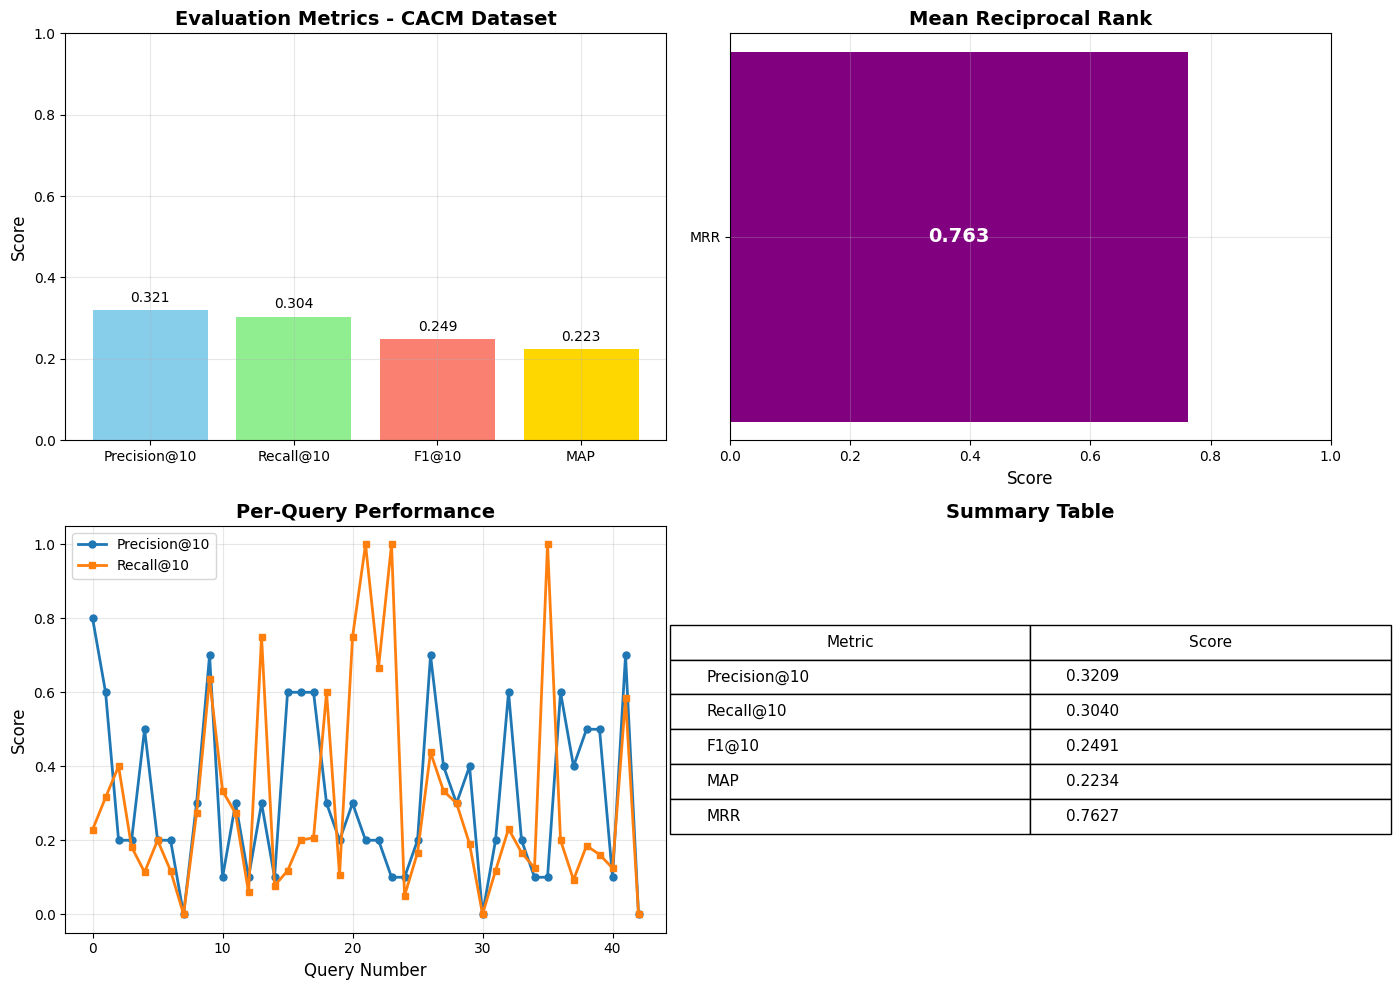


✅ Evaluation visualization completed!


In [22]:
# Visualisasi metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Precision@10', 'Recall@10', 'F1@10', 'MAP']
scores = [mean_scores[m] for m in metrics]

# Bar chart
axes[0, 0].bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Evaluation Metrics - CACM Dataset', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 1)
for i, (m, s) in enumerate(zip(metrics, scores)):
    axes[0, 0].text(i, s + 0.02, f'{s:.3f}', ha='center', fontsize=10)

# MRR visualization
axes[0, 1].barh(['MRR'], [mean_scores['MRR']], color='purple')
axes[0, 1].set_xlabel('Score', fontsize=12)
axes[0, 1].set_title('Mean Reciprocal Rank', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 1)
axes[0, 1].text(mean_scores['MRR']/2, 0, f'{mean_scores["MRR"]:.3f}', 
                ha='center', va='center', fontsize=14, fontweight='bold', color='white')

# Detailed scores per query
axes[1, 0].plot(range(len(all_scores['precision'])), all_scores['precision'], 
                'o-', label='Precision@10', linewidth=2, markersize=5)
axes[1, 0].plot(range(len(all_scores['recall'])), all_scores['recall'], 
                's-', label='Recall@10', linewidth=2, markersize=5)
axes[1, 0].set_xlabel('Query Number', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Per-Query Performance', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Summary table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for metric in metrics + ['MRR']:
    table_data.append([metric, f'{mean_scores[metric]:.4f}'])
table = axes[1, 1].table(cellText=table_data, colLabels=['Metric', 'Score'], 
                        cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
axes[1, 1].set_title('Summary Table', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Evaluation visualization completed!")


## 17. Visualisasi Hasil Evaluasi CISI
- **Subplot 1 (Bar Chart)**: Menampilkan Precision@10, Recall@10, F1@10, dan MAP
- **Subplot 2 (MRR Bar)**: Menampilkan Mean Reciprocal Rank
- **Subplot 3 (Summary Table)**: Tabel ringkasan semua metrik

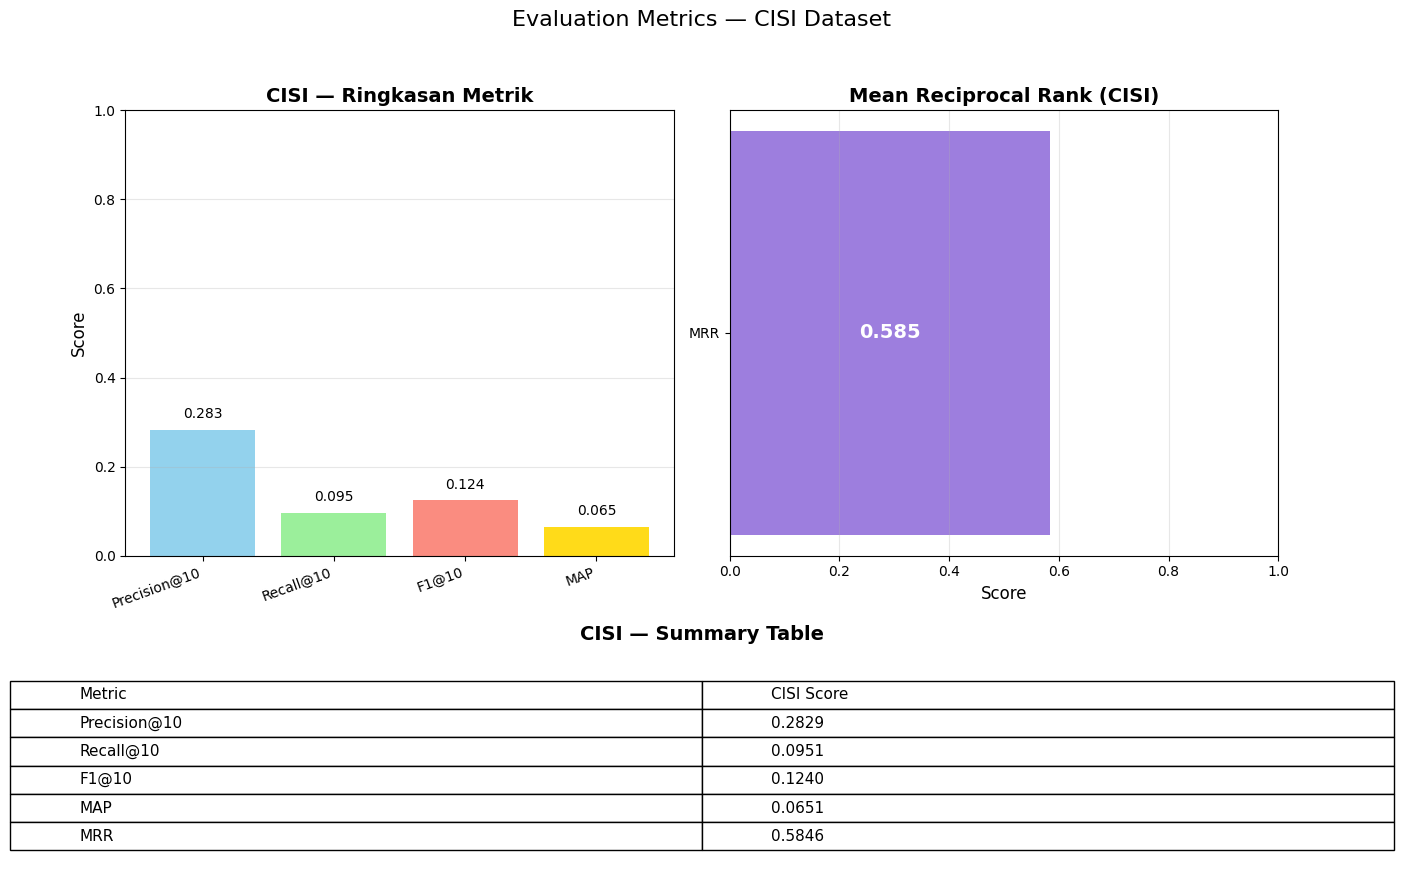


✅ CISI evaluation visualization completed!

=== SUMMARY — CISI ===
Metric               Score
----------------------------
Precision@10        0.2829
Recall@10           0.0951
F1@10               0.1240
MAP                 0.0651
MRR                 0.5846


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- Guard: pastikan data CISI ada ---
if 'cisi_mean_scores' not in globals():
    raise RuntimeError("Data CISI belum tersedia. Pastikan 'cisi_mean_scores' sudah dibuat.")
if not isinstance(cisi_mean_scores, dict):
    raise TypeError("'cisi_mean_scores' harus dict berisi nilai metrik.")

# --- Data ringkasan ---
metrics = ['Precision@10', 'Recall@10', 'F1@10', 'MAP']
scores  = [float(cisi_mean_scores.get(m, 0.0)) for m in metrics]
mrr_val = float(cisi_mean_scores.get('MRR', 0.0))

# --- Figure layout: 2 kolom di atas (bar & MRR), 1 table full-width di bawah ---
fig = plt.figure(figsize=(14, 9))
gs = GridSpec(2, 2, height_ratios=[2, 1], figure=fig)
ax_bar  = fig.add_subplot(gs[0, 0])
ax_mrr  = fig.add_subplot(gs[0, 1])
ax_tbl  = fig.add_subplot(gs[1, :])

fig.suptitle('Evaluation Metrics — CISI Dataset', fontsize=16, y=0.98)

# (1) Bar chart ringkasan
colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
x = np.arange(len(metrics))
ax_bar.bar(x, scores, color=colors, alpha=0.9)
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(metrics, rotation=20, ha='right')
ax_bar.set_ylabel('Score', fontsize=12)
ax_bar.set_title('CISI — Ringkasan Metrik', fontsize=14, fontweight='bold')
ax_bar.grid(True, alpha=0.3, axis='y')
ax_bar.set_ylim(0, 1)

# anotasi nilai di atas bar
for i, s in enumerate(scores):
    ax_bar.text(i, min(0.98, s + 0.02), f'{s:.3f}', ha='center', va='bottom', fontsize=10)

# (2) MRR horizontal
ax_mrr.barh(['MRR'], [mrr_val], color='mediumpurple', alpha=0.9)
ax_mrr.set_xlim(0, 1)
ax_mrr.set_xlabel('Score', fontsize=12)
ax_mrr.set_title('Mean Reciprocal Rank (CISI)', fontsize=14, fontweight='bold')
ax_mrr.grid(True, alpha=0.3, axis='x')

# label besar di dalam/tepi bar
ax_mrr.text(
    mrr_val/2 if mrr_val > 0.15 else max(0.03, mrr_val + 0.02),
    0, f'{mrr_val:.3f}',
    ha='center' if mrr_val > 0.15 else 'left',
    va='center',
    fontsize=14, fontweight='bold',
    color='white' if mrr_val > 0.15 else 'black'
)

# (3) Summary table (full width)
ax_tbl.axis('off')
table_rows = [[m, f'{cisi_mean_scores.get(m, 0.0):.4f}'] for m in metrics] + [['MRR', f'{mrr_val:.4f}']]
tbl = ax_tbl.table(
    cellText=table_rows,
    colLabels=['Metric', 'CISI Score'],
    cellLoc='left',
    colLoc='left',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1.2, 1.6)
ax_tbl.set_title('CISI — Summary Table', fontsize=14, fontweight='bold', pad=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Print angka ringkas di console ---
print("\n✅ CISI evaluation visualization completed!")
print("\n=== SUMMARY — CISI ===")
print(f"{'Metric':<15} {'Score':>10}")
print("-" * 28)
for m, s in zip(metrics, scores):
    print(f"{m:<15} {s:>10.4f}")
print(f"{'MRR':<15} {mrr_val:>10.4f}")


In [24]:
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

print("Memulai eksperimen untuk menemukan jumlah cluster terbaik pada dataset CISI...")

# Define the range of clusters to test
cluster_range = range(1, 21)  # Test from 1 to 20 clusters
cisi_all_results = []

# IMPORTANT: Use the full query set for this evaluation
full_cisi_queries = cisi_queries

# Redefine search function for CISI
def cisi_search_exp(query, top_n=10, k=60):
    query_tokens = preprocess(query)
    query_raw_text = query.lower()
    
    # Find winning cluster using the experimental models
    query_vector = cisi_tfidf_vectorizer.transform([query_raw_text])
    similarities = cosine_similarity(query_vector, cisi_centroids_exp)[0]
    winning_cluster = int(np.argmax(similarities))
    sub_corpus_indices = cisi_cluster_to_docs_exp.get(winning_cluster, [])
    
    if not sub_corpus_indices:
        return []

    # BM25 rankings (uses original global BM25 models)
    all_title_scores = cisi_bm25_title.get_scores(query_tokens)
    title_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sorted([(idx, all_title_scores[idx]) for idx in sub_corpus_indices], key=lambda x: x[1], reverse=True))}
    
    all_abstract_scores = cisi_bm25_abstract.get_scores(query_tokens)
    abstract_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sorted([(idx, all_abstract_scores[idx]) for idx in sub_corpus_indices], key=lambda x: x[1], reverse=True))}
    
    # RRF
    rrf_scores = defaultdict(float)
    for doc_idx in sub_corpus_indices:
        score = 0.0
        if doc_idx in title_rank_map: score += 1 / (k + title_rank_map[doc_idx])
        if doc_idx in abstract_rank_map: score += 1 / (k + abstract_rank_map[doc_idx])
        rrf_scores[doc_idx] = score
    
    sorted_scores = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [{'id': cisi_docs[doc_idx]['id']} for doc_idx, _ in sorted_scores[:top_n]]

# --- Main Loop for CISI ---
for n_clusters in cluster_range:
    print(f"\nMenguji dengan {n_clusters} clusters...")
    start_time = time.time()

    # 1. Re-run K-Means and create experiment-specific global variables
    kmeans_exp = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_exp = kmeans_exp.fit_predict(cisi_tfidf_matrix)
    cisi_centroids_exp = kmeans_exp.cluster_centers_
    
    cisi_cluster_to_docs_exp = defaultdict(list)
    for doc_idx, cluster_id in enumerate(cluster_labels_exp):
        cisi_cluster_to_docs_exp[cluster_id].append(doc_idx)

    # 2. Run Evaluation on the FULL query set
    mean_scores, _ = evaluate_search(cisi_docs, full_cisi_queries, cisi_qrels, cisi_search_exp, top_n=10)
    end_time = time.time()
    mean_scores['n_clusters'] = n_clusters
    cisi_all_results.append(mean_scores)
    print(f"Selesai dalam {end_time - start_time:.2f} detik. MRR: {mean_scores.get('MRR', 0):.4f}, F1@10: {mean_scores.get('F1@10', 0):.4f}")
print("\n--- Eksperimen CISI Selesai ---")


Memulai eksperimen untuk menemukan jumlah cluster terbaik pada dataset CISI...

Menguji dengan 1 clusters...
Selesai dalam 4.57 detik. MRR: 0.5598, F1@10: 0.1473

Menguji dengan 2 clusters...
Selesai dalam 4.21 detik. MRR: 0.5626, F1@10: 0.1367

Menguji dengan 3 clusters...
Selesai dalam 4.23 detik. MRR: 0.5846, F1@10: 0.1240

Menguji dengan 4 clusters...
Selesai dalam 3.69 detik. MRR: 0.5500, F1@10: 0.1170

Menguji dengan 5 clusters...
Selesai dalam 3.75 detik. MRR: 0.5310, F1@10: 0.1095

Menguji dengan 6 clusters...
Selesai dalam 3.84 detik. MRR: 0.5342, F1@10: 0.1050

Menguji dengan 7 clusters...
Selesai dalam 4.43 detik. MRR: 0.4191, F1@10: 0.0908

Menguji dengan 8 clusters...
Selesai dalam 4.22 detik. MRR: 0.5422, F1@10: 0.0915

Menguji dengan 9 clusters...
Selesai dalam 3.82 detik. MRR: 0.5321, F1@10: 0.0848

Menguji dengan 10 clusters...
Selesai dalam 4.34 detik. MRR: 0.5302, F1@10: 0.0885

Menguji dengan 11 clusters...
Selesai dalam 4.36 detik. MRR: 0.5015, F1@10: 0.0915

Mengu

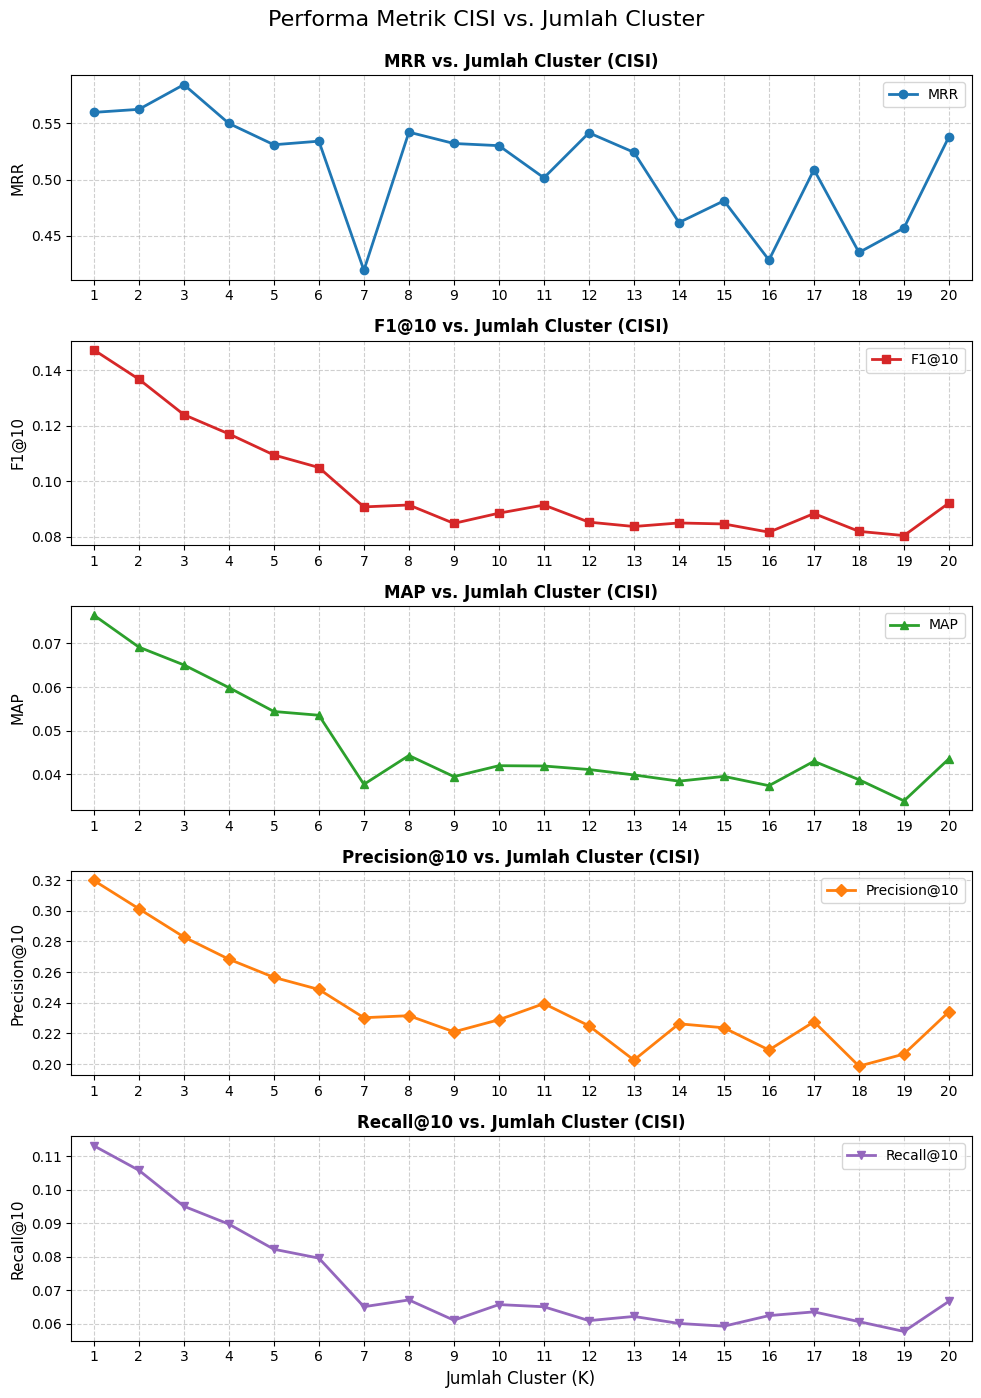


=== RINGKASAN HASIL EKSPERIMEN CISI ===
Metric               Max        n_clusters  
------------------------------------------
MRR                  0.5846     3           
F1@10                0.1473     1           
MAP                  0.0765     1           


In [25]:
# --- Plotting CISI Results ---
if cisi_all_results:
    # Extract data
    n_clusters_vals = [res['n_clusters'] for res in cisi_all_results]
    mrr_vals = [res.get('MRR', 0) for res in cisi_all_results]
    f1_vals  = [res.get('F1@10', 0) for res in cisi_all_results]
    map_vals = [res.get('MAP', 0) for res in cisi_all_results]
    prec_vals = [res.get('Precision@10', 0) for res in cisi_all_results]
    recall_vals = [res.get('Recall@10', 0) for res in cisi_all_results]

    xticks_vals = sorted(set(int(k) for k in n_clusters_vals))
    xmin, xmax = min(xticks_vals), max(xticks_vals)

    # Create 5 subplots
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 14), sharex=False)
    fig.suptitle('Performa Metrik CISI vs. Jumlah Cluster', fontsize=16, y=0.995)

    # Plot 1: MRR
    ax1.plot(n_clusters_vals, mrr_vals, 'o-', label='MRR', color='tab:blue', linewidth=2, markersize=6)
    ax1.set_ylabel('MRR', fontsize=11)
    ax1.set_title('MRR vs. Jumlah Cluster (CISI)', fontsize=12, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='best')
    ax1.set_xticks(xticks_vals)
    ax1.set_xlim(xmin - 0.5, xmax + 0.5)

    # Plot 2: F1@10
    ax2.plot(n_clusters_vals, f1_vals, 's-', label='F1@10', color='tab:red', linewidth=2, markersize=6)
    ax2.set_ylabel('F1@10', fontsize=11)
    ax2.set_title('F1@10 vs. Jumlah Cluster (CISI)', fontsize=12, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='best')
    ax2.set_xticks(xticks_vals)
    ax2.set_xlim(xmin - 0.5, xmax + 0.5)

    # Plot 3: MAP
    ax3.plot(n_clusters_vals, map_vals, '^-', label='MAP', color='tab:green', linewidth=2, markersize=6)
    ax3.set_ylabel('MAP', fontsize=11)
    ax3.set_title('MAP vs. Jumlah Cluster (CISI)', fontsize=12, fontweight='bold')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(loc='best')
    ax3.set_xticks(xticks_vals)
    ax3.set_xlim(xmin - 0.5, xmax + 0.5)

    # Plot 4: Precision@10
    ax4.plot(n_clusters_vals, prec_vals, 'D-', label='Precision@10', color='tab:orange', linewidth=2, markersize=6)
    ax4.set_ylabel('Precision@10', fontsize=11)
    ax4.set_title('Precision@10 vs. Jumlah Cluster (CISI)', fontsize=12, fontweight='bold')
    ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.legend(loc='best')
    ax4.set_xticks(xticks_vals)
    ax4.set_xlim(xmin - 0.5, xmax + 0.5)

    # Plot 5: Recall@10
    ax5.plot(n_clusters_vals, recall_vals, 'v-', label='Recall@10', color='tab:purple', linewidth=2, markersize=6)
    ax5.set_ylabel('Recall@10', fontsize=11)
    ax5.set_xlabel('Jumlah Cluster (K)', fontsize=12)
    ax5.set_title('Recall@10 vs. Jumlah Cluster (CISI)', fontsize=12, fontweight='bold')
    ax5.grid(True, linestyle='--', alpha=0.6)
    ax5.legend(loc='best')
    ax5.set_xticks(xticks_vals)
    ax5.set_xlim(xmin - 0.5, xmax + 0.5)

    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n=== RINGKASAN HASIL EKSPERIMEN CISI ===")
    print(f"{'Metric':<20} {'Max':<10} {'n_clusters':<12}")
    print("-" * 42)
    
    if mrr_vals:
        max_mrr_idx = np.argmax(mrr_vals)
        print(f"{'MRR':<20} {max(mrr_vals):<10.4f} {n_clusters_vals[max_mrr_idx]:<12}")
    
    if f1_vals:
        max_f1_idx = np.argmax(f1_vals)
        print(f"{'F1@10':<20} {max(f1_vals):<10.4f} {n_clusters_vals[max_f1_idx]:<12}")
    
    if map_vals:
        max_map_idx = np.argmax(map_vals)
        print(f"{'MAP':<20} {max(map_vals):<10.4f} {n_clusters_vals[max_map_idx]:<12}")
else:
    print("Tidak ada hasil untuk CISI yang dapat diplot.")


---

In [26]:


print("Memulai eksperimen untuk menemukan jumlah cluster terbaik...")
cluster_range = range(1, 31) 
all_results = []
full_cacm_queries = cacm_queries 
def cacm_search_exp(query, top_n=10, k=60):
    query_tokens = preprocess(query)
    query_raw_text = query.lower()
    query_vector = cacm_tfidf_vectorizer.transform([query_raw_text])
    similarities = cosine_similarity(query_vector, cacm_centroids_exp)[0]
    winning_cluster = int(np.argmax(similarities))
    sub_corpus_indices = cacm_cluster_to_docs_exp.get(winning_cluster, [])
    
    if not sub_corpus_indices:
        return []

    # BM25
    all_title_scores = cacm_bm25_title.get_scores(query_tokens)
    title_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sorted([(idx, all_title_scores[idx]) for idx in sub_corpus_indices], key=lambda x: x[1], reverse=True))}
    
    all_abstract_scores = cacm_bm25_abstract.get_scores(query_tokens)
    abstract_rank_map = {doc_idx: rank+1 for rank, (doc_idx, _) in enumerate(sorted([(idx, all_abstract_scores[idx]) for idx in sub_corpus_indices], key=lambda x: x[1], reverse=True))}
    
    # RRF
    rrf_scores = defaultdict(float)
    for doc_idx in sub_corpus_indices:
        score = 0.0
        if doc_idx in title_rank_map: score += 1 / (k + title_rank_map[doc_idx])
        if doc_idx in abstract_rank_map: score += 1 / (k + abstract_rank_map[doc_idx])
        rrf_scores[doc_idx] = score
    
    sorted_scores = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [{'id': cacm_docs[doc_idx]['id']} for doc_idx, _ in sorted_scores[:top_n]]

# --- Main Loop ---
for n_clusters in cluster_range:
    print(f"\nMenguji dengan {n_clusters} clusters...")
    start_time = time.time()
    kmeans_exp = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels_exp = kmeans_exp.fit_predict(cacm_tfidf_matrix)
    cacm_centroids_exp = kmeans_exp.cluster_centers_
    
    cacm_cluster_to_docs_exp = defaultdict(list)
    for doc_idx, cluster_id in enumerate(cluster_labels_exp):
        cacm_cluster_to_docs_exp[cluster_id].append(doc_idx)
    mean_scores, _ = evaluate_search(cacm_docs, full_cacm_queries, cacm_qrels, cacm_search_exp, top_n=10)
    end_time = time.time()
    mean_scores['n_clusters'] = n_clusters
    all_results.append(mean_scores)
    print(f"Selesai dalam {end_time - start_time:.2f} detik. MRR: {mean_scores.get('MRR', 0):.4f}, F1@10: {mean_scores.get('F1@10', 0):.4f}")
print("\n--- Eksperimen Selesai ---")



Memulai eksperimen untuk menemukan jumlah cluster terbaik...

Menguji dengan 1 clusters...
Selesai dalam 2.38 detik. MRR: 0.7714, F1@10: 0.2447

Menguji dengan 2 clusters...
Selesai dalam 2.12 detik. MRR: 0.7694, F1@10: 0.2494

Menguji dengan 3 clusters...
Selesai dalam 2.48 detik. MRR: 0.7627, F1@10: 0.2491

Menguji dengan 4 clusters...
Selesai dalam 1.67 detik. MRR: 0.7598, F1@10: 0.2467

Menguji dengan 5 clusters...
Selesai dalam 2.01 detik. MRR: 0.7365, F1@10: 0.2424

Menguji dengan 6 clusters...
Selesai dalam 1.97 detik. MRR: 0.7404, F1@10: 0.2460

Menguji dengan 7 clusters...
Selesai dalam 1.85 detik. MRR: 0.7016, F1@10: 0.2311

Menguji dengan 8 clusters...
Selesai dalam 2.06 detik. MRR: 0.7127, F1@10: 0.2422

Menguji dengan 9 clusters...
Selesai dalam 2.18 detik. MRR: 0.6863, F1@10: 0.2086

Menguji dengan 10 clusters...
Selesai dalam 3.05 detik. MRR: 0.6977, F1@10: 0.2317

Menguji dengan 11 clusters...
Selesai dalam 2.58 detik. MRR: 0.6471, F1@10: 0.2097

Menguji dengan 12 clust

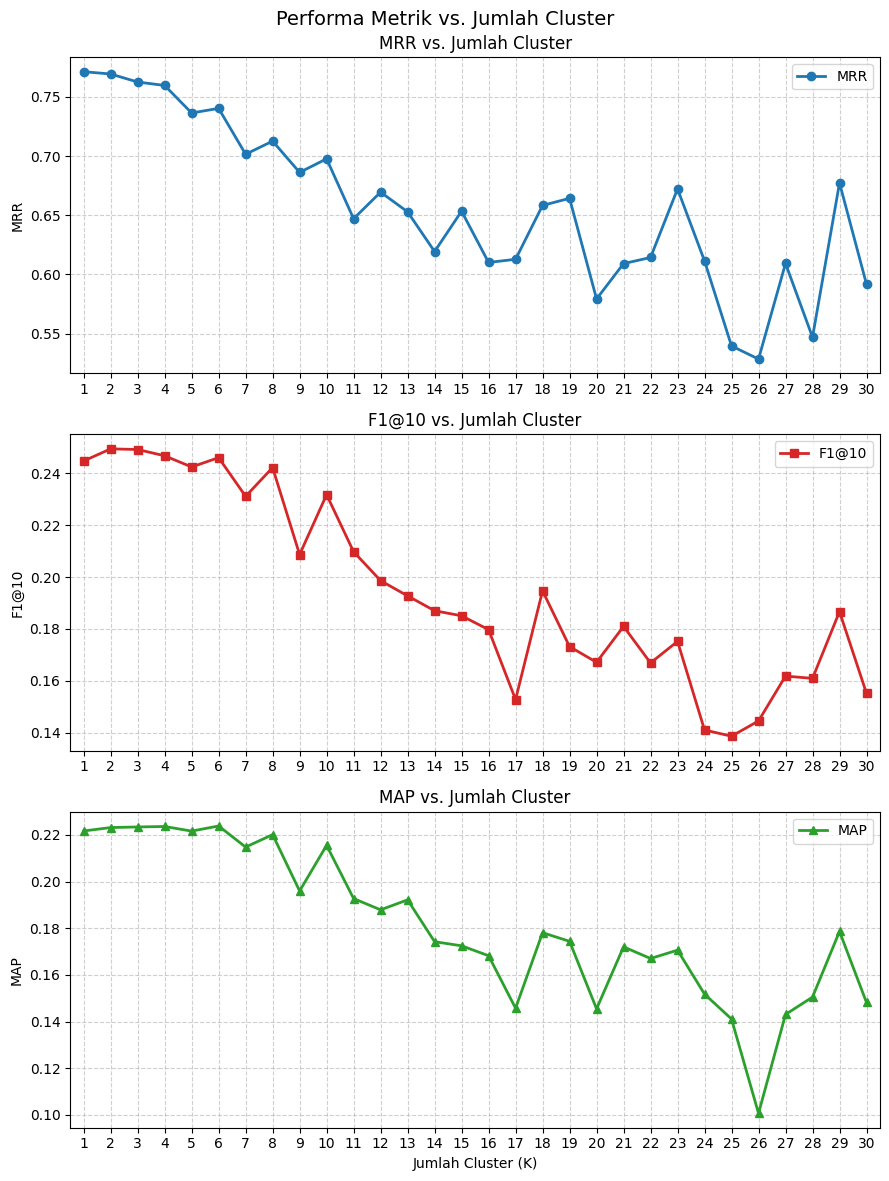

In [27]:

    n_clusters_vals = [res['n_clusters'] for res in all_results]
    mrr_vals = [res.get('MRR', 0) for res in all_results]
    f1_vals  = [res.get('F1@10', 0) for res in all_results]
    map_vals = [res.get('MAP', 0) for res in all_results]
    xticks_vals = sorted(set(int(k) for k in n_clusters_vals))
    xmin, xmax = min(xticks_vals), max(xticks_vals)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12), sharex=False)
    fig.suptitle('Performa Metrik vs. Jumlah Cluster', fontsize=14, y=0.98)

    # --- Plot 1: MRR ---
    ax1.plot(n_clusters_vals, mrr_vals, 'o-', label='MRR', color='tab:blue', linewidth=2, markersize=6)
    ax1.set_ylabel('MRR')
    ax1.set_title('MRR vs. Jumlah Cluster', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='best')
    ax1.set_xticks(xticks_vals)
    ax1.set_xlim(xmin - 0.5, xmax + 0.5) 

    # --- Plot 2: F1@10 ---
    ax2.plot(n_clusters_vals, f1_vals, 's-', label='F1@10', color='tab:red', linewidth=2, markersize=6)
    ax2.set_ylabel('F1@10')
    ax2.set_title('F1@10 vs. Jumlah Cluster', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='best')
    ax2.set_xticks(xticks_vals)
    ax2.set_xlim(xmin - 0.5, xmax + 0.5)

    # --- Plot 3: MAP ---
    ax3.plot(n_clusters_vals, map_vals, '^-', label='MAP', color='tab:green', linewidth=2, markersize=6)
    ax3.set_ylabel('MAP')
    ax3.set_title('MAP vs. Jumlah Cluster', fontsize=12)
    ax3.set_xlabel('Jumlah Cluster (K)')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(loc='best')
    ax3.set_xticks(xticks_vals)
    ax3.set_xlim(xmin - 0.5, xmax + 0.5)

    plt.tight_layout()
    plt.show()


## Perbandingan CACM vs CISI

Bagian ini membandingkan hasil eksperimen antara dataset CACM dan CISI:
- **Plot 1**: Line plot MRR vs jumlah cluster untuk kedua dataset
- **Plot 2**: Bar chart MRR optimal untuk kedua dataset
- **Summary table**: Tabel perbandingan best K dan best metrics


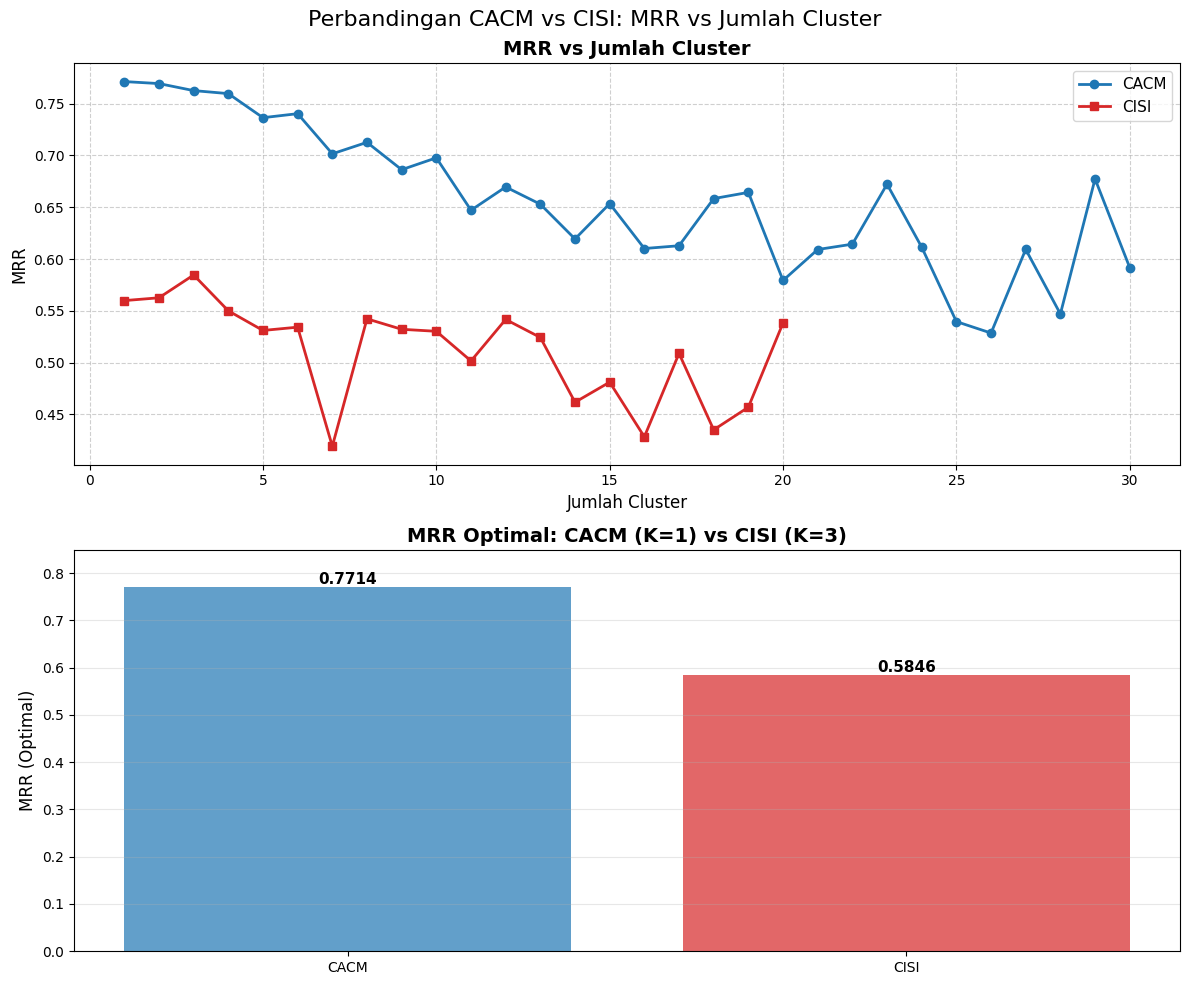


RINGKASAN PERBANDINGAN CACM vs CISI
Dataset         Best K     Best MRR        Best F1@10     
------------------------------------------------------------
CACM            1          0.7714          0.2447         
CISI            3          0.5846          0.1240         


In [28]:

    cacm_n_clusters = [res['n_clusters'] for res in all_results]
    cacm_mrr = [res.get('MRR', 0) for res in all_results]
    cisi_n_clusters = [res['n_clusters'] for res in cisi_all_results]
    cisi_mrr = [res.get('MRR', 0) for res in cisi_all_results]
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('Perbandingan CACM vs CISI: MRR vs Jumlah Cluster', fontsize=16, y=0.98)
    
    # Plot 1
    ax1 = axes[0]
    ax1.plot(cacm_n_clusters, cacm_mrr, 'o-', label='CACM', color='tab:blue', linewidth=2, markersize=6)
    ax1.plot(cisi_n_clusters, cisi_mrr, 's-', label='CISI', color='tab:red', linewidth=2, markersize=6)
    ax1.set_xlabel('Jumlah Cluster', fontsize=12)
    ax1.set_ylabel('MRR', fontsize=12)
    ax1.set_title('MRR vs Jumlah Cluster', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot 2
    ax2 = axes[1]
    cacm_best_idx = np.argmax(cacm_mrr)
    cisi_best_idx = np.argmax(cisi_mrr)
    
    cacm_best_k = cacm_n_clusters[cacm_best_idx]
    cisi_best_k = cisi_n_clusters[cisi_best_idx]
    
    datasets = ['CACM', 'CISI']
    best_k_values = [cacm_best_k, cisi_best_k]
    best_mrr_values = [cacm_mrr[cacm_best_idx], cisi_mrr[cisi_best_idx]]
    
    bars = ax2.bar(datasets, best_mrr_values, color=['tab:blue', 'tab:red'], alpha=0.7)
    ax2.set_ylabel('MRR (Optimal)', fontsize=12)
    ax2.set_title(f'MRR Optimal: CACM (K={cacm_best_k}) vs CISI (K={cisi_best_k})', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, max(best_mrr_values) * 1.1)
    

    for i, (bar, val) in enumerate(zip(bars, best_mrr_values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("\n" + "="*60)
    print("RINGKASAN PERBANDINGAN CACM vs CISI")
    print("="*60)
    print(f"{'Dataset':<15} {'Best K':<10} {'Best MRR':<15} {'Best F1@10':<15}")
    print("-" * 60)
    
    cacm_best_f1 = all_results[cacm_best_idx].get('F1@10', 0)
    cisi_best_f1 = cisi_all_results[cisi_best_idx].get('F1@10', 0)
    
    print(f"{'CACM':<15} {cacm_best_k:<10} {cacm_mrr[cacm_best_idx]:<15.4f} {cacm_best_f1:<15.4f}")
    print(f"{'CISI':<15} {cisi_best_k:<10} {cisi_mrr[cisi_best_idx]:<15.4f} {cisi_best_f1:<15.4f}")
    print("="*60)
